## Initialize

In [16]:
import rasterio
import numpy as np
import baseline_comparison as bs
import matplotlib.pyplot as plt
import numexpr as ne
from utility import dem

# compute surface normals


def compute_normals(Z):
    print("computing normals")
    dzdx = np.gradient(Z, axis=1)
    dzdy = np.gradient(Z, axis=0)

    # Surface normal vector at each point
    nx = -dzdx
    ny = -dzdy
    nz = np.ones_like(Z)
    normals = np.dstack((nx, ny, nz))
    norm = np.linalg.norm(normals, axis=2, keepdims=True)
    return normals / norm


def compute_look_vector(satellite_position, X, Y, Z):
    # Build 3D grid of points from DEM
    print("building 3D grid of points")
    points = np.dstack((X, Y, Z))

    # Vector from satellite to ground points
    print("computing look vector for exch point")
    look_vec = points - satellite_position.reshape(1, 1, 3)

    # Normalize
    print("normalizing look vector")
    look_vec /= np.linalg.norm(look_vec, axis=2, keepdims=True)


def look_vector_from_angles(azimuth_angle, look_angle):
    az = np.deg2rad(azimuth_angle)
    el = np.deg2rad(90 - look_angle)  # elevation = 90 - off_nadir

    x = np.sin(el) * np.sin(az)
    y = np.sin(el) * np.cos(az)
    z = np.cos(el)
    print(f"look vector: {x}, {y}, {z}")
    return np.array([x, y, -z])  # assuming sensor looks downwards


def lambertian(normals, look_vec):
    print("computing lambertian reflectance")
    # Lambertian reflectance
    dot = np.sum(normals * look_vec, axis=2)  # No reshape needed
    reflectance = np.clip(dot, 0, 1)
    return reflectance

# input files
dem_file = "input_data/alletch_tip_UTM.tif"
satellite_file = "input_data/ICEYE_X13_SLC_SLEA_1106641_20220908T012002.xml"

Optional: improved algorthm for 'compute normals'

In [18]:

def compute_normals(Z):
    print("computing normals")
    dzdx = np.gradient(Z, axis=1)
    dzdy = np.gradient(Z, axis=0)
    nx = -dzdx
    ny = -dzdy
    nz = np.ones_like(Z)
    norm = ne.evaluate("sqrt(nx**2 + ny**2 + nz**2)")
    return np.dstack((nx, ny, nz)) / norm[..., np.newaxis]

## Creating a test pyramid dem

In [19]:
def create_pyramid_dem(size, max_height):
    """
    Create a synthetic pyramid-shaped DEM.

    Parameters:
    size (int): The size of the DEM grid (size x size).
    max_height (float): The maximum elevation at the center of the pyramid.

    Returns:
    np.ndarray: A 2D array representing the pyramid-shaped DEM.
    """
    # Create a grid of coordinates
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)

    # Calculate the distance from the center
    distance = np.maximum(np.abs(X), np.abs(Y))

    # Assign elevation values (highest at the center, decreasing outward)
    Z = max_height * (1 - distance)

    return Z

# Parameters
size = 100  # Size of the DEM grid (100x100)
max_height = 1000  # Maximum elevation at the center

# Create the pyramid DEM
pyramid_dem = create_pyramid_dem(size, max_height)


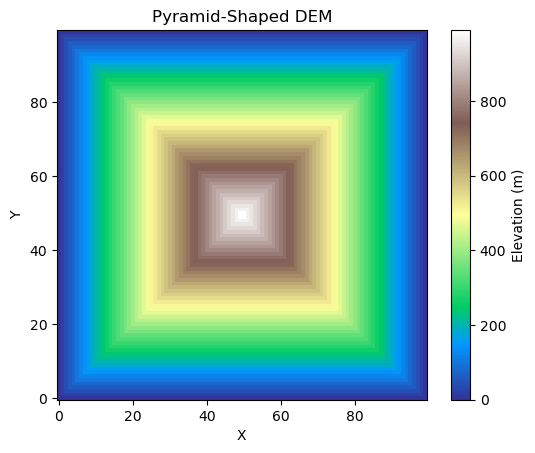

In [20]:
# Visualize the DEM
plt.imshow(pyramid_dem, cmap="terrain", origin="lower")
plt.colorbar(label="Elevation (m)")
plt.title("Pyramid-Shaped DEM")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [21]:
Z = pyramid_dem

## Use this for the real DEM

In [5]:
alletch = dem.from_file(dem_file)

Reading DEM file: input_data/alletch_tip_UTM.tif


In [9]:
alletch = alletch.null_threshold(0)

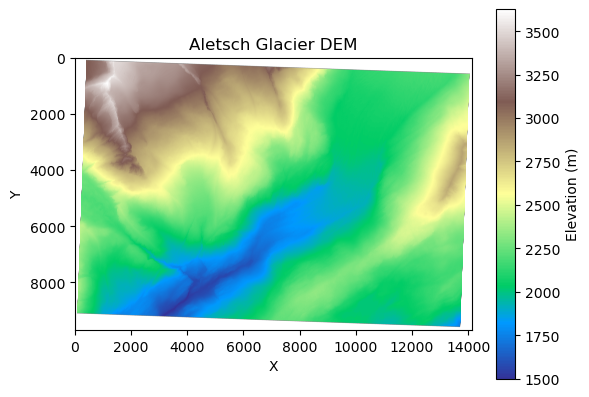

In [45]:
plt.imshow(alletch.dem_data, cmap="terrain")
plt.colorbar(label="Elevation (m)")
plt.title("Aletsch Glacier DEM")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [40]:
rows, cols = alletch.dem_data.shape
x_coords = np.arange(cols) * alletch.transform.a + alletch.transform.c
y_coords = np.arange(rows) * alletch.transform.e + alletch.transform.f
X, Y = np.meshgrid(x_coords, y_coords)
Z = alletch.dem_data

## Computation part
Generate normal map

In [41]:
normals = compute_normals(Z)
look_vec = [1, -1, 0]

computing normals


In [37]:
look_angle, azimuth_angle = bs.extract_angles(satellite_file)
look_vec = bs.compute_u_LOS(look_angle, azimuth_angle)
print (look_vec)

[-0.01017161  0.84706085  0.53139858]


In [20]:
look_angle, azimuth_angle = bs.extract_angles(satellite_file)
look_vec = look_vector_from_angles(azimuth_angle, look_angle)

look vector: -0.010171612309465474, 0.8470608525892279, 0.5313985795180829


In [43]:
reflectance = lambertian(normals, look_vec)

computing lambertian reflectance


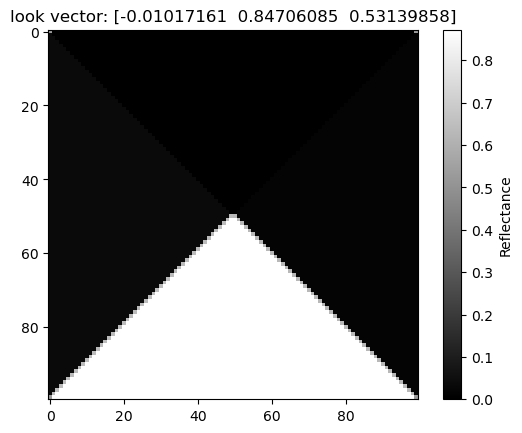

In [39]:
plt.imshow(reflectance, cmap="gray")
plt.title(f"look vector: {look_vec}")
plt.colorbar(label="Reflectance")
plt.show()

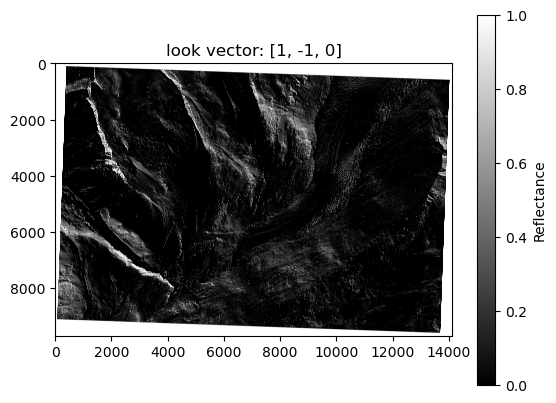

In [44]:
plt.imshow(reflectance, cmap="gray")
plt.title(f"look vector: {look_vec}")
plt.colorbar(label="Reflectance")
plt.show()